In [55]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
import re

# 데이터 불러오기
df = pd.read_csv('/data/ephemeral/home/level2-nlp-datacentric-nlp-15/data/aug15000_8515.csv')

# 데이터셋 클래스 정의
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 예측 확률 얻기 함수
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    softmax = torch.nn.Softmax(dim=1)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = softmax(outputs.logits)
            predictions.extend(probs.cpu().numpy())
    
    return np.array(predictions)

# 텍스트 품질 검사 함수
def check_text_quality(text):
    # 아스키코드나 특수문자 비율 계산
    special_chars = len(re.findall(r'[^\w\s가-힣]', text))
    total_chars = len(text)
    special_char_ratio = special_chars / total_chars if total_chars > 0 else 1
    
    # 한글 비율 계산
    korean_chars = len(re.findall(r'[가-힣]', text))
    korean_ratio = korean_chars / total_chars if total_chars > 0 else 0
    
    return special_char_ratio, korean_ratio

# 모델과 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=7)

# 데이터셋 준비
text_dataset = TextDataset(df['text'].tolist(), df['target'].tolist(), tokenizer)
dataloader = DataLoader(text_dataset, batch_size=32)

# GPU 사용 가능시 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
# 예측 확률 얻기
pred_probs = get_predictions(model, dataloader, device)

100%|██████████| 488/488 [00:12<00:00, 37.64it/s]


In [81]:
# 데이터 품질 분석
quality_scores = []
for idx, row in df.iterrows():
    text = row['text']
    special_ratio, korean_ratio = check_text_quality(text)
    max_prob = np.max(pred_probs[idx])
    
    # 품질 점수 계산 (낮을수록 제거 대상)
    quality_score = (
        (1 - special_ratio) * 0.3 +  # 특수문자 비율이 낮을수록 좋음
        korean_ratio * 0.6 +         # 한글 비율이 높을수록 좋음
        max_prob * 0.1               # 예측 신뢰도가 높을수록 좋음
    )
    
    quality_scores.append({
        'index': idx,
        'text': text,
        'special_ratio': special_ratio,
        'korean_ratio': korean_ratio,
        'prediction_confidence': max_prob,
        'quality_score': quality_score
    })

# 품질 점수를 데이터프레임으로 변환
quality_df = pd.DataFrame(quality_scores)

In [75]:
print("\n품질 점수 0.50 이하인 데이터:")
very_low_quality = quality_df[quality_df['quality_score'] <= 0.50]
print(f"총 {len(very_low_quality)}개 발견")

print("\n샘플 :")
for _, row in very_low_quality.head(239).iterrows():
    print("\n" + "="*80)
    print(f"텍스트: {row['text']}")
    print(f"특수문자 비율: {row['special_ratio']:.3f}")
    print(f"한글 비율: {row['korean_ratio']:.3f}")
    print(f"예측 신뢰도: {row['prediction_confidence']:.3f}")
    print(f"품질 점수: {row['quality_score']:.3f}")


품질 점수 0.50 이하인 데이터:
총 239개 발견

샘플 :

텍스트: Korean Cultural Center USA Teams Up with Local Artists for Cultural Exchange Program
특수문자 비율: 0.000
한글 비율: 0.000
예측 신뢰도: 0.203
품질 점수: 0.320

텍스트: 中国民众参与决策：新时代的新期待
특수문자 비율: 0.062
한글 비율: 0.000
예측 신뢰도: 0.172
품질 점수: 0.298

텍스트: ExWanna One Member Minhyun Joins New Idol Group
특수문자 비율: 0.000
한글 비율: 0.000
예측 신뢰도: 0.230
품질 점수: 0.323

텍스트: 朴大統領、北京訪問で北朝鮮問題と経済協調で意見交換
특수문자 비율: 0.040
한글 비율: 0.000
예측 신뢰도: 0.183
품질 점수: 0.306

텍스트: 北朝鮮ミサイル発射、韓米安保協議加速へ
특수문자 비율: 0.053
한글 비율: 0.000
예측 신뢰도: 0.180
품질 점수: 0.302

텍스트: 英国单词知识问答引爆社交网络热潮
특수문자 비율: 0.000
한글 비율: 0.000
예측 신뢰도: 0.191
품질 점수: 0.319

텍스트: 中国企业助力防疫 专家参与疫情防控策略制定
특수문자 비율: 0.000
한글 비율: 0.000
예측 신뢰도: 0.177
품질 점수: 0.318

텍스트: "ARM架构芯片市场掀起新波：英特尔强势布局"
특수문자 비율: 0.130
한글 비율: 0.000
예측 신뢰도: 0.191
품질 점수: 0.280

텍스트: AI 时代，程序员的命运：Github Copilot 与 Amazon CodeWhisperer 的较量
특수문자 비율: 0.037
한글 비율: 0.000
예측 신뢰도: 0.198
품질 점수: 0.309

텍스트: Galaxy Fold Repair: Samsung Addresses Screen Issues in Major Recall
특수문자 비율: 0.015
한글 비율: 0.00

In [76]:
# 품질 점수가 0.5 이하인 데이터의 인덱스 확인
low_quality_indices = quality_df[quality_df['quality_score'] <= 0.5]['index'].values
print(f"제거할 데이터 수: {len(low_quality_indices)}")

제거할 데이터 수: 239


In [77]:
# 원본 데이터에서 해당 인덱스를 제외한 데이터만 선택
clean_df = df.drop(index=low_quality_indices)
print(f"정제된 데이터 수: {len(clean_df)}")

정제된 데이터 수: 15352


In [78]:
# 정제된 데이터의 라벨 분포 확인
print("\n정제된 데이터의 라벨 분포:")
print(clean_df['target'].value_counts())


정제된 데이터의 라벨 분포:
target
4    2331
3    2270
5    2208
1    2186
0    2178
2    2108
6    2071
Name: count, dtype: int64


<Axes: xlabel='target'>

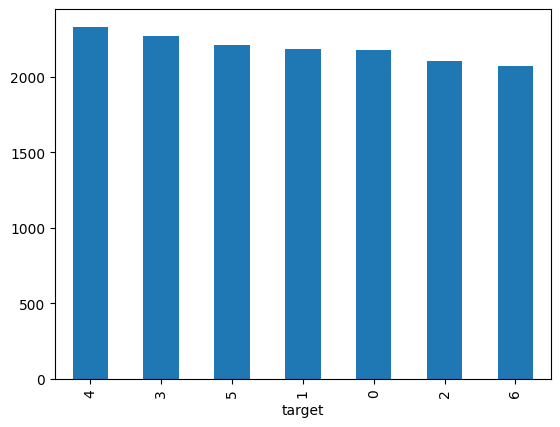

In [79]:
import matplotlib.pyplot as plt
clean_df['target'].value_counts().plot(kind='bar')

In [80]:
# 파일 저장
clean_df.to_csv('/data/ephemeral/home/level2-nlp-datacentric-nlp-15/data/15000_cleanlab.csv', index=False)
print("\n정제된 데이터를 '15000_cleanlab.csv'로 저장했습니다.")


정제된 데이터를 '15000_cleanlab.csv'로 저장했습니다.
